In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np #Importing basic libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My\ Drive/Project\ 2

/content/drive/My Drive/Project 2


In [4]:
import json
df = pd.read_json(r'Sarcasm_Headlines_Dataset.json',lines = True) #Reading the dataset

In [5]:
df.head() #Let's explore the dataset

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [6]:
df['is_sarcastic'].value_counts() #Fairly equal number of both values of the target variable, we can expect an unbiased algorithm.

0    14985
1    13634
Name: is_sarcastic, dtype: int64

In [7]:
#Checking the dataset for duplicate values
df.duplicated().value_counts() #2 duplicate entries are present

False    28617
True         2
dtype: int64

In [8]:
df1 = df.drop_duplicates() #Dropping the duplicated entries.

In [9]:
#Checking if any null values are present in the dataset.
df1.isna().any() #No null values are present in the dataset.

is_sarcastic    False
headline        False
article_link    False
dtype: bool

In [10]:
#Dropping the column 'article_link', as it's not required for training the algorithm.
df2 = df1.drop('article_link',axis=1)

In [11]:
target = df2['is_sarcastic'] #Separating the target variable

In [12]:
from nltk.tokenize import RegexpTokenizer
import regex as re
def clean_text(headline):
  headline = re.sub(r"'","",headline) #Removing inverted comma first.
  words = RegexpTokenizer("[a-zA-Z0-9]+").tokenize(headline) #Taking only alphanumeric symbols
  cleaned_headline = " ".join(words) #Since the data is already lowercased and the stopwords are required for context, no further cleaning is required.
  return cleaned_headline

headline = df2['headline'].apply(clean_text)

In [13]:
import random
for i in range(5):
  #Let's print 5 random headlines with their lengths.
  j = random.randrange(0,len(headline),1)
  length = len(headline[j])
  print(headline[j]," ",length)

ratings low for npr morning zoo crew   36
genetically modified broccoli shrieks benefits at shopper   57
smooth transaction at dmv exaggerated into story anyway   55
aspiring felon moved by man who didnt get first 8 convictions until his 60s   75
heres what actually happens to the money in wishing wells   57


In [14]:
#Let's print maximum possible length of a headline.
max_len = max([len(i) for i in headline])
print(max_len)

911


In [15]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

In [16]:
max_features = 10000
maxlen = max_len
embedding_size = 50

In [17]:
tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
tokenizer.fit_on_texts(headline) #Using keras tokenizer for getting word indices

In [18]:
X = tokenizer.texts_to_sequences(headline)
X = pad_sequences(X, maxlen = maxlen) #Padding the shorter headlines
y = np.asarray(target) #Features and labels have been created now

In [19]:
num_words=len(tokenizer.word_index)
print (num_words) #Size of vocabulary

27176


In [20]:
embeddings = {}
for o in open('DataSet - glove.6B.50d.txt'):
    word = o.split(" ")[0]
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    embeddings[word] = embd #Getting the word embeddings from the provided Glove vectors' file.

In [25]:
embedding_matrix = np.zeros((num_words+1, 50))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector #Creating the embedding matrix.

In [28]:
import tensorflow as tf
#Creating a bidirectional lstm with basic parameters
input_layer = Input(shape=(maxlen,),dtype=tf.int64)
embed = Embedding(embedding_matrix.shape[0],output_dim=50,weights=[embedding_matrix],input_length=maxlen, trainable=True)(input_layer)
lstm=Bidirectional(LSTM(128))(embed)
drop=Dropout(0.3)(lstm)
dense =Dense(100,activation='relu')(drop)
out=Dense(2,activation='softmax')(dense)

In [29]:
batch_size = 100
epochs = 5

model = Model(input_layer,out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 911)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 911, 50)           1358850   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              183296    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                             

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/5
229/229 [==============================] - 35s 97ms/step - loss: 0.5062 - accuracy: 0.7443
Epoch 2/5
229/229 [==============================] - 22s 96ms/step - loss: 0.3086 - accuracy: 0.8677
Epoch 3/5
229/229 [==============================] - 22s 98ms/step - loss: 0.2225 - accuracy: 0.9104
Epoch 4/5
229/229 [==============================] - 23s 102ms/step - loss: 0.1683 - accuracy: 0.9360
Epoch 5/5
229/229 [==============================] - 24s 104ms/step - loss: 0.1308 - accuracy: 0.9518


In [31]:
y_pred = [np.argmax(i) for i in model.predict(X_test)]

In [33]:
from sklearn.metrics import accuracy_score, f1_score
print("Test accuracy: ",accuracy_score(y_test,y_pred))
print("Test f1 score: ",f1_score(y_test,y_pred)) #Printing the model performance on test data

Test accuracy:  0.8649545772187281
Test f1 score:  0.8525653251954988


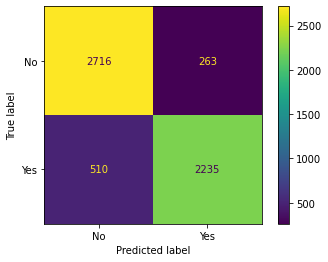

In [36]:
from sklearn import metrics
cm=metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
disp.plot() #From the confusion matrix of test set, we can see that the model is more biased towards interpreting a headline as non sarcastic than it is to interpreting the headline as sarcastic